# Traffic Data Analysis
<span style="color:red">This notebook analyzes on traffic congestion prediction, identifying peak hours, Junction Comparison & Analysis and evaluate the performance of predictive models to forecast hourly traffic volumes at different road junctions.</span>

## Import necessary library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

## Loading DataSet and Understanding the Data

In [2]:
df=pd.read_csv("Dataset_Uber Traffic.csv")

In [3]:
#Taking overview of the data
df.head(10)

,DateTime,Junction,Vehicles,ID
0,01/11/15 0:00,1,15,20151101001
1,01/11/15 1:00,1,13,20151101011
2,01/11/15 2:00,1,10,20151101021
3,01/11/15 3:00,1,7,20151101031
4,01/11/15 4:00,1,9,20151101041
5,01/11/15 5:00,1,6,20151101051
6,01/11/15 6:00,1,9,20151101061
7,01/11/15 7:00,1,8,20151101071
8,01/11/15 8:00,1,11,20151101081
9,01/11/15 9:00,1,12,20151101091


In [4]:
# descriptive statistics of a DataFrame.
df.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [5]:
# checking data type of columns 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


## Data Cleaning and Preprocessing

<span style="color:red">'''
 Dropping ID Column since it doesn't provide predictive information about the number of vehicles or other features. 
'''</span>

In [6]:
df=df.drop('ID',axis=1)

In [7]:
#To check any null value present or not
df.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
dtype: int64

In [8]:
df.duplicated().value_counts()
# To check data contains duplicated rows or not

False    48120
Name: count, dtype: int64

In [9]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%y %H:%M')

In [10]:
# storing DateTime column for future reference since for time based plotting it is necessary to keep it as index
DateTime=df['DateTime']

In [11]:
# Converting timestamp column in the datetime format for proper time-based operations.
df.set_index('DateTime',inplace=True)

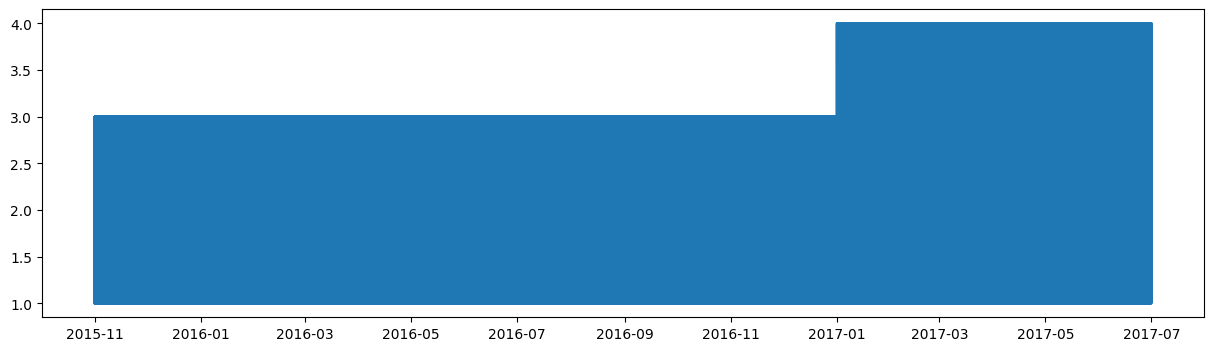

In [12]:
''' plotting DateTime vs Junction  '''
df_sorted=df.sort_index()
plt.figure(figsize=(15,4))
plt.plot(df_sorted['Junction'])

 <span style="color:red">''' there is no duplicated row in the dataset, But the DateTime column has repeated value for Junction 1,2,3 and Junction 4 data is available from Jan 2017 onwards '''</span>

In [13]:
print(df[df['Junction']==1].shape)
print(df[df['Junction']==2].shape)
print(df[df['Junction']==3].shape)
print(df[df['Junction']==4].shape)

(14592, 2)
(14592, 2)
(14592, 2)
(4344, 2)


## Exploratory Data Analysis

- Plotting Distribution of Vehicles count throughout the time

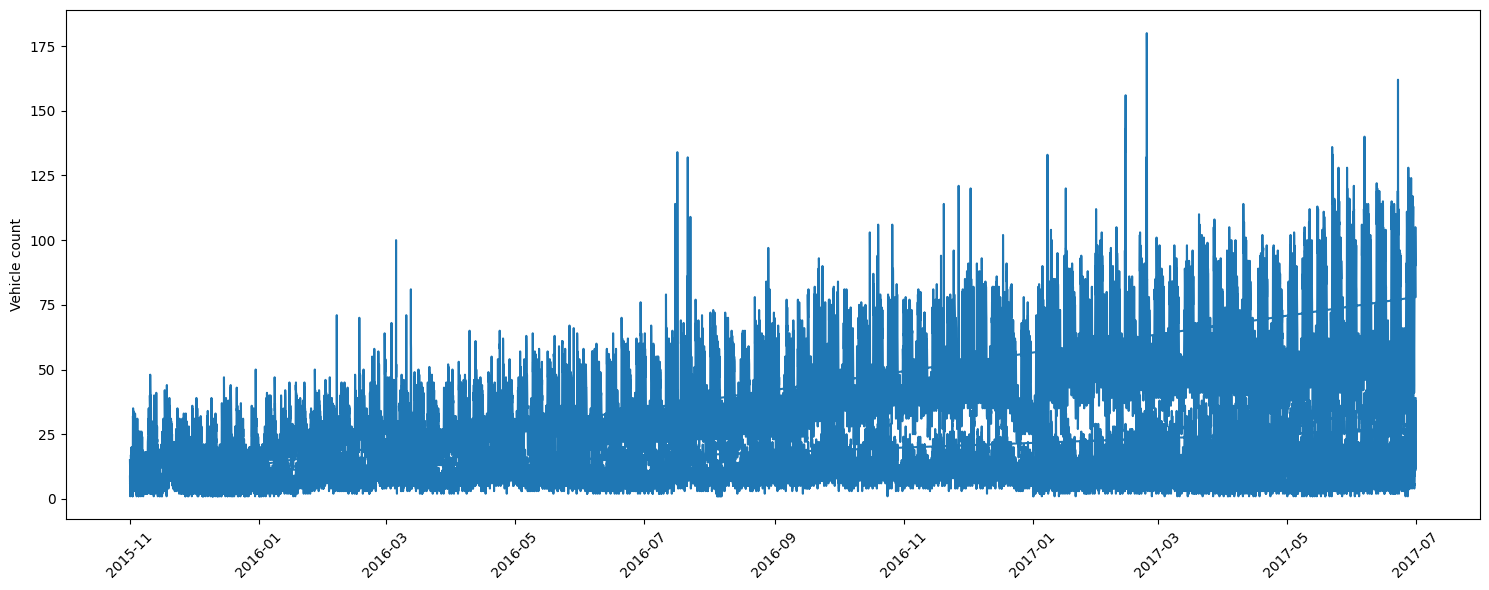

In [14]:
plt.figure(figsize=(15, 6))
X=pd.Series(df['Vehicles'])
plt.plot(X)
plt.xticks(rotation=45)
plt.ylabel('Vehicle count')
plt.tight_layout()

- plotting histogram  with kde and boxplot of vehicle


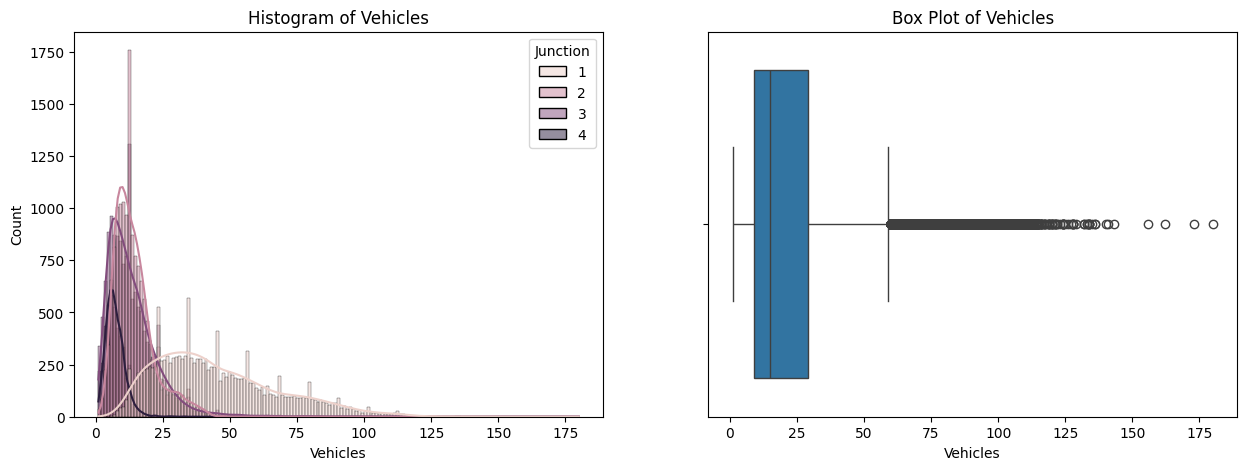

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the histogram on the first axis
sns.histplot(ax=ax1, data=df, x='Vehicles', kde=True,hue='Junction')
ax1.set_title('Histogram of Vehicles')

# Plot the box plot on the second axis
sns.boxplot(ax=ax2, x='Vehicles', data=df)
ax2.set_title('Box Plot of Vehicles')

# Display the plot
plt.show()

- removing outlier can affect capturing the variability in modelling.

# Feature Engineering


In [16]:
df['date_year']=df.index.year            #Extracting year
df['date_month']=df.index.month          # Extracting month name
df['date_days']=df.index.day             # Extracting days
df['day_hour']=df.index.hour             # Extracting hours
df['day_of_week']=df.index.day_of_week   # Extracting day of week


df['date_is_weekend']=np.where(df['day_of_week'].isin([5,6]),1,0)   # is weekend?
df.sample(5) 

,Junction,Vehicles,date_year,date_month,date_days,day_hour,day_of_week,date_is_weekend
DateTime,,,,,,,,
2016-02-08 10:00:00,1,36,2016,2,8,10,0,0
2017-05-01 18:00:00,4,5,2017,5,1,18,0,0
2016-10-17 17:00:00,2,19,2016,10,17,17,0,0
2015-12-30 10:00:00,1,22,2015,12,30,10,2,0
2016-09-22 01:00:00,2,16,2016,9,22,1,3,0


### Setting Congestion level based on vehicle counts at junctions

In [17]:
df['Congestion_level']=np.where(df['Vehicles']<=60,'low',
                                np.where((df['Vehicles']>60 ) & (df['Vehicles']<=120),'medium',
                                'high'))

In [18]:
df.head(5)

,Junction,Vehicles,date_year,date_month,date_days,day_hour,day_of_week,date_is_weekend,Congestion_level
DateTime,,,,,,,,,
2015-11-01 00:00:00,1,15,2015,11,1,0,6,1,low
2015-11-01 01:00:00,1,13,2015,11,1,1,6,1,low
2015-11-01 02:00:00,1,10,2015,11,1,2,6,1,low
2015-11-01 03:00:00,1,7,2015,11,1,3,6,1,low
2015-11-01 04:00:00,1,9,2015,11,1,4,6,1,low


### Compile traffic data into hourly intervals for each junction.

In [19]:
grouped_df = df.groupby(['Junction', 'day_hour']).agg({'Vehicles': 'sum'}).reset_index()
grouped_df

,Junction,day_hour,Vehicles
0,1,0,27809
1,1,1,23807
2,1,2,20616
3,1,3,17894
4,1,4,15598
...,...,...,...
91,4,19,1602
92,4,20,1636
93,4,21,1525
94,4,22,1586


<Axes: xlabel='day_hour', ylabel='Vehicles'>

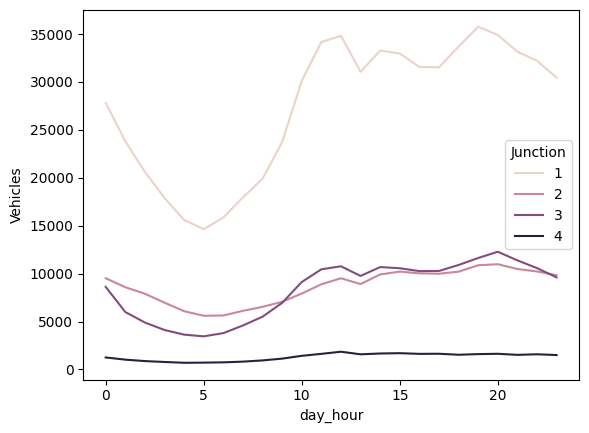

In [20]:
sns.lineplot(x='day_hour',y='Vehicles',data=grouped_df,hue='Junction')

- <span style="color:red">We can see that Junction 1 is very busy area among all junctions, specially from  8:00 AM</span>
- <span style="color:red">While Junction 4 has very less vehicles count</span>
- <span style="color:red">Junction 2 and 3 has low to moderate vehicle count</span>

### Plotting autocorrelation, partial autocorrelation to get an idea about the k significant lag features

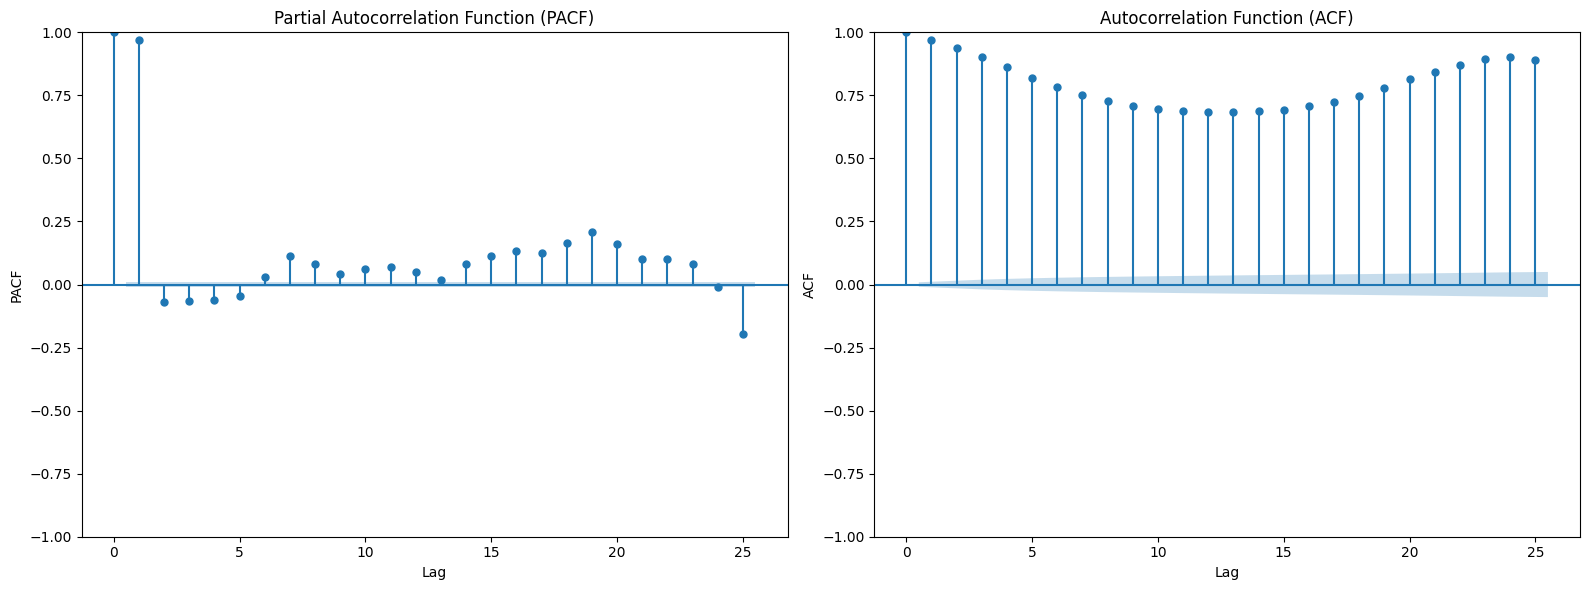

In [21]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot PACF
plot_pacf(df['Vehicles'], lags=25, alpha=0.05, ax=ax1)
ax1.set_title('Partial Autocorrelation Function (PACF)')
ax1.set_xlabel('Lag')
ax1.set_ylabel('PACF')

# Plot ACF
plot_acf(df['Vehicles'], lags=25, alpha=0.05, ax=ax2)
ax2.set_title('Autocorrelation Function (ACF)')
ax2.set_xlabel('Lag')
ax2.set_ylabel('ACF')

plt.tight_layout()
plt.show()


- <span style="color:red">The ACF plot exhibits a decaying pattern with significant spikes across multiple lags, suggesting that an Autoregressive Moving Average (ARMA) or Autoregressive Integrated Moving Average (ARIMA) model might be appropriate if the time series is stationary or needs differencing, respectively.</span>
- <span style="color:red">The PACF plot indicates that lags 1 and 2 are most significant, but we can also consider including additional lags up to where the PACF becomes insignificant, typically around lag 5 or 6 based on the plot.</span>

### creating lag features of Vehicles from previous hours to capture temporal dependencies

In [22]:
# Create hourly lags fro vehicle column
df['Vehicles_lag1'] = df['Vehicles'].shift(1)  # Lag of 1 hour
df['Vehicles_lag2'] = df['Vehicles'].shift(2)  # Lag of 2 hours
df['Vehicles_lag3'] = df['Vehicles'].shift(3)  # Lag of 3 hours
df['Vehicles_lag4'] = df['Vehicles'].shift(4)  # Lag of 4 hours
df['Vehicles_lag5'] = df['Vehicles'].shift(5)  # Lag of 5 hours


In [23]:
df.head(5)

,Junction,Vehicles,date_year,date_month,date_days,day_hour,day_of_week,date_is_weekend,Congestion_level,Vehicles_lag1,Vehicles_lag2,Vehicles_lag3,Vehicles_lag4,Vehicles_lag5
DateTime,,,,,,,,,,,,,,
2015-11-01 00:00:00,1,15,2015,11,1,0,6,1,low,NaN,NaN,NaN,NaN,NaN
2015-11-01 01:00:00,1,13,2015,11,1,1,6,1,low,15.0,NaN,NaN,NaN,NaN
2015-11-01 02:00:00,1,10,2015,11,1,2,6,1,low,13.0,15.0,NaN,NaN,NaN
2015-11-01 03:00:00,1,7,2015,11,1,3,6,1,low,10.0,13.0,15.0,NaN,NaN
2015-11-01 04:00:00,1,9,2015,11,1,4,6,1,low,7.0,10.0,13.0,15.0,NaN


In [24]:
# df=df.bfill()

### Normalize or standardize the data to facilitate comparison across different time periods and junctions.

In [25]:
# Instantiate the scaler
scaler = MinMaxScaler()

# Select the features to normalize
numerical_cols = ['Vehicles', 'date_month', 'date_days', 'day_hour', 'Vehicles_lag1', 'Vehicles_lag2', 'Vehicles_lag3','Vehicles_lag4','Vehicles_lag5']

# Apply the scaler to the selected features
normalized_data = scaler.fit_transform(df[numerical_cols])
# One-hot encode categorical features with get_dummies
encoded_data = pd.get_dummies(df,columns=['Junction', 'day_of_week', 'date_year', 'Congestion_level'], drop_first=True)
encoded_data.reset_index(inplace=True)
# Convert the normalized data back to a DataFrame and retain column names
normalized_df = pd.DataFrame(normalized_data, columns=[f"{col}_normalized" for col in numerical_cols])

# Concatenate the encoded DataFrame with the normalized DataFrame
df_norm = pd.concat([encoded_data, normalized_df], axis=1)

# Display the updated DataFrame with both original and normalized features
boolean_columns = df_norm.select_dtypes(include=['bool']).columns
df_norm[boolean_columns] = df_norm[boolean_columns].astype(int)
df_norm=df_norm.drop(numerical_cols,axis=1)
df_norm.head(5)

,DateTime,date_is_weekend,Junction_2,Junction_3,Junction_4,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,...,Congestion_level_medium,Vehicles_normalized,date_month_normalized,date_days_normalized,day_hour_normalized,Vehicles_lag1_normalized,Vehicles_lag2_normalized,Vehicles_lag3_normalized,Vehicles_lag4_normalized,Vehicles_lag5_normalized
0,2015-11-01 00:00:00,1,0,0,0,0,0,0,0,0,...,0,0.078212,0.909091,0.0,0.000000,NaN,NaN,NaN,NaN,NaN
1,2015-11-01 01:00:00,1,0,0,0,0,0,0,0,0,...,0,0.067039,0.909091,0.0,0.043478,0.078212,NaN,NaN,NaN,NaN
2,2015-11-01 02:00:00,1,0,0,0,0,0,0,0,0,...,0,0.050279,0.909091,0.0,0.086957,0.067039,0.078212,NaN,NaN,NaN
3,2015-11-01 03:00:00,1,0,0,0,0,0,0,0,0,...,0,0.033520,0.909091,0.0,0.130435,0.050279,0.067039,0.078212,NaN,NaN
4,2015-11-01 04:00:00,1,0,0,0,0,0,0,0,0,...,0,0.044693,0.909091,0.0,0.173913,0.033520,0.050279,0.067039,0.078212,NaN


## correlation analysis of features with the target variable- 'Vehicle' 

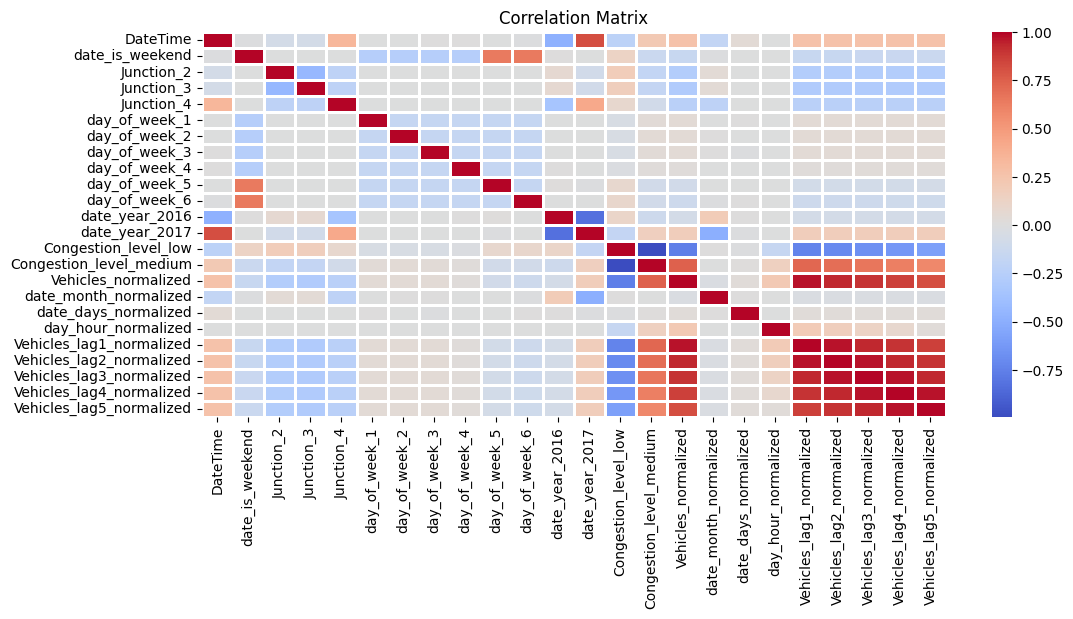

Correlation with the target variable 'Vehicle' 

Vehicles_normalized         1.000000
Vehicles_lag1_normalized    0.969982
Vehicles_lag2_normalized    0.936816
Vehicles_lag3_normalized    0.900645
Vehicles_lag4_normalized    0.861642
Vehicles_lag5_normalized    0.820818
Congestion_level_medium     0.746052
DateTime                    0.266244
day_hour_normalized         0.219938
date_year_2017              0.180481
day_of_week_1               0.049153
day_of_week_3               0.046517
day_of_week_2               0.046454
date_days_normalized        0.027895
day_of_week_4               0.019910
date_month_normalized      -0.022723
date_year_2016             -0.074470
day_of_week_5              -0.082969
day_of_week_6              -0.111422
date_is_weekend            -0.150550
Junction_4                 -0.235915
Junction_2                 -0.271457
Junction_3                 -0.289236
Congestion_level_low       -0.758496
Name: Vehicles_normalized, dtype: float64


In [26]:
correlation_matrix = df_norm.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12,5))

sns.heatmap(correlation_matrix,linewidths=2, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

print("Correlation with the target variable 'Vehicle' \n")
target_correlation = correlation_matrix['Vehicles_normalized'].sort_values(ascending=False)
print(target_correlation)

- <span style="color:red">The lag features (Vehicles_lagX_normalized) have strong negative correlations with the target variable 'Vehicle', indicating their significance in time series forecasting.</span>
- <span style="color:red">Although date_month_normalized and date_days_normalized have low correlations, they may still be useful for capturing seasonal or long-term trends in traffic patterns.</span>
- <span style="color:red">Features like day_of_week, day_hour_normalized, and junction features (Junction_2, Junction_3, Junction_4) have relatively weak correlations with the target variable. However, these features are still crucial for performing weekly/hourly traffic analysis and junction comparisons, as they capture the temporal and spatial patterns of traffic.</span>

### Feature Importance measure using Random Forest

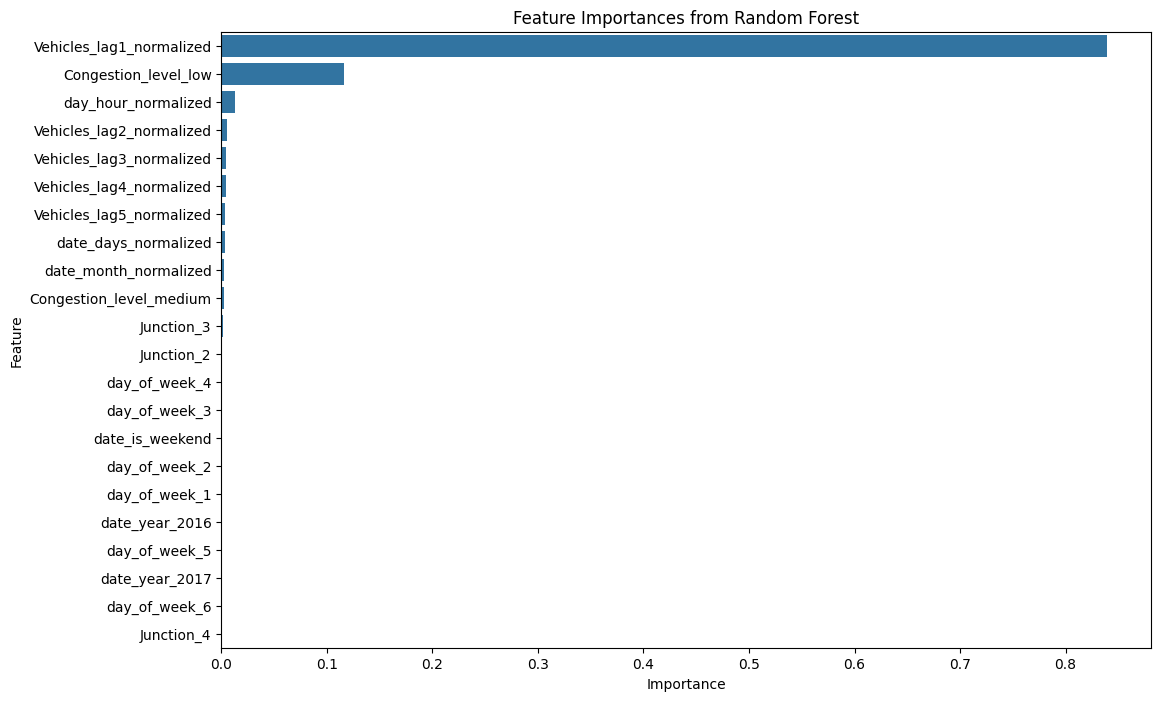

In [27]:
X = df_norm.drop(columns=['Vehicles_normalized','DateTime'])  # Dropping target and datetime columns
y = df_norm['Vehicles_normalized']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()


## Data Collection & Integration

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

In [29]:
# Loading weather dataset
df2=pd.read_csv("weather.csv")

In [30]:
# Taking overview of weather data
df2.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2009-01-01 00:00:00,27,12,0.0,11.6,5,1,31,09:58 AM,10:03 PM,...,18,11,2,91,0.0,1014,14,10,109,8
1,2009-01-01 01:00:00,27,12,0.0,11.6,5,1,31,09:58 AM,10:03 PM,...,17,9,2,93,0.0,1014,14,7,85,6
2,2009-01-01 02:00:00,27,12,0.0,11.6,5,1,31,09:58 AM,10:03 PM,...,16,7,2,94,0.0,1014,13,5,61,4
3,2009-01-01 03:00:00,27,12,0.0,11.6,5,1,31,09:58 AM,10:03 PM,...,15,5,2,96,0.0,1014,12,2,37,3
4,2009-01-01 04:00:00,27,12,0.0,11.6,5,1,31,09:58 AM,10:03 PM,...,18,5,1,88,0.0,1015,14,5,45,3


In [31]:
# Renaming DateTime column
df2=df2.rename(columns={'date_time':'DateTime'})

In [32]:
# Extracting relevant columns for Integration
df2=df2[['DateTime','tempC','humidity','precipMM','windspeedKmph']]

In [33]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96432 entries, 0 to 96431
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DateTime       96432 non-null  object 
 1   tempC          96432 non-null  int64  
 2   humidity       96432 non-null  int64  
 3   precipMM       96432 non-null  float64
 4   windspeedKmph  96432 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 3.7+ MB


In [34]:
# Converting DateTime datatype(object) to DateTime format
df2['DateTime'] = pd.to_datetime(df2['DateTime'], format='%Y-%m-%d %H:%M:%S')

In [35]:
# Create junctions in weather dataframe(df2)

'''As our traffic dataframe has traffic data throughout the year for every Junction so by creating junctions in weather 
   dataframe we can make data available for using in traffic dataframe by adding some little variations to the all features 
'''

junctions = [1, 2, 3, 4]
dfs = []

for junction in junctions:
    temp_df = df2.copy()
    temp_df['Junction'] = junction
    
    # Add random variations to the columns
    
    temp_df['tempC'] += np.random.uniform(-1, 1, size=len(temp_df))
    temp_df['humidity'] += np.random.uniform(-2, 2, size=len(temp_df))
    temp_df['precipMM'] += np.random.uniform(0, 0.1, size=len(temp_df))
    temp_df['windspeedKmph'] += np.random.uniform(-1, 1, size=len(temp_df))
    
    dfs.append(temp_df)

# Concatenate all dataframes
weather_df = pd.concat(dfs, ignore_index=True)

weather_df.shape


(385728, 6)

''' <span style="color:red">There are 385728 rows in weather dataframe after creating Junction column , while our traffic dataset has 48120 rows.
    Therefore we will merge both Dataframe based on common DateTime,Junction Features
    </span>
'''

In [36]:
weather_df.head()

,DateTime,tempC,humidity,precipMM,windspeedKmph,Junction
0,2009-01-01 00:00:00,13.546818,92.194109,0.064693,7.825851,1
1,2009-01-01 01:00:00,13.370272,94.314089,0.057869,5.562142,1
2,2009-01-01 02:00:00,13.144851,93.637413,0.047249,3.452811,1
3,2009-01-01 03:00:00,11.232771,97.805167,0.082197,2.152056,1
4,2009-01-01 04:00:00,14.046213,89.454755,0.048503,2.956062,1


In [37]:
df.head(5)

,Junction,Vehicles,date_year,date_month,date_days,day_hour,day_of_week,date_is_weekend,Congestion_level,Vehicles_lag1,Vehicles_lag2,Vehicles_lag3,Vehicles_lag4,Vehicles_lag5
DateTime,,,,,,,,,,,,,,
2015-11-01 00:00:00,1,15,2015,11,1,0,6,1,low,NaN,NaN,NaN,NaN,NaN
2015-11-01 01:00:00,1,13,2015,11,1,1,6,1,low,15.0,NaN,NaN,NaN,NaN
2015-11-01 02:00:00,1,10,2015,11,1,2,6,1,low,13.0,15.0,NaN,NaN,NaN
2015-11-01 03:00:00,1,7,2015,11,1,3,6,1,low,10.0,13.0,15.0,NaN,NaN
2015-11-01 04:00:00,1,9,2015,11,1,4,6,1,low,7.0,10.0,13.0,15.0,NaN


In [38]:
weather_df.set_index('DateTime', inplace=True)

### Integrate data from various sources:
- Creating custom Estimator to merge differnet dataframes

In [39]:
class DataFrameMerger(BaseEstimator, TransformerMixin):
    def __init__(self, df1, df2, on, how='inner'):
        self.df1 = df1
        self.df2 = df2
        self.on = on
        self.how = how
        self.merged_df = None  # Initialize merged_df attribute

    def fit(self, X, y=None):
        # No fitting needed, so simply return self
        return self

    def transform(self, X, y=None):
        if self.merged_df is None:  # Check if merged_df has been computed
            self.merged_df = pd.merge(self.df1, self.df2, on=self.on, how=self.how)
            return self.merged_df 
        else:
            return X

# Create the custom transformer instance
merger = DataFrameMerger(df, weather_df, on=['DateTime', 'Junction'])

# Transform to perform the merge (if not already done)
merged_df=merger.transform(None)

# Now you can access the merged dataframe if needed
merged_df = merged_df.reset_index(drop=False)

# Save the merged DataFrame to a CSV file
merged_df.to_csv('merged_data.csv')


In [40]:
merged_df.head(5)

,DateTime,Junction,Vehicles,date_year,date_month,date_days,day_hour,day_of_week,date_is_weekend,Congestion_level,Vehicles_lag1,Vehicles_lag2,Vehicles_lag3,Vehicles_lag4,Vehicles_lag5,tempC,humidity,precipMM,windspeedKmph
0,2015-11-01 00:00:00,1,15,2015,11,1,0,6,1,low,NaN,NaN,NaN,NaN,NaN,20.048152,93.852230,0.077140,8.441724
1,2015-11-01 01:00:00,1,13,2015,11,1,1,6,1,low,15.0,NaN,NaN,NaN,NaN,19.893698,94.380935,0.013807,8.678710
2,2015-11-01 02:00:00,1,10,2015,11,1,2,6,1,low,13.0,15.0,NaN,NaN,NaN,20.090335,96.395309,0.018752,6.659544
3,2015-11-01 03:00:00,1,7,2015,11,1,3,6,1,low,10.0,13.0,15.0,NaN,NaN,19.035396,96.817509,0.007654,6.106404
4,2015-11-01 04:00:00,1,9,2015,11,1,4,6,1,low,7.0,10.0,13.0,15.0,NaN,20.487096,90.748969,0.086652,9.763010


In [41]:
merged_df.shape

(48120, 19)

- train test split on merged DataFrame

In [42]:
X = merged_df.drop(columns=['Vehicles'])
y = merged_df['Vehicles']

train_size = int(len(X) * 0.7)  # 70% for training
val_size = int(len(X) * 0.15)   # 15% for validation
test_size = len(X) - train_size - val_size  # the rest for testing

# Splitting into training, validation, and test sets based on time
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_val = X.iloc[train_size:train_size + val_size]
y_val = y.iloc[train_size:train_size + val_size]

X_test = X.iloc[train_size + val_size:]
y_test = y.iloc[train_size + val_size:]

# Column indices for one-hot encoding
categorical_features = ['Junction', 'date_year', 'date_month', 'day_of_week', 'date_is_weekend', 'Congestion_level']
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_features]

numerical_features = ['Vehicles_lag1', 'Vehicles_lag2', 'Vehicles_lag3', 'Vehicles_lag4', 'Vehicles_lag5','tempC','humidity','precipMM','windspeedKmph','date_days','day_hour']
numerical_indices = [X_train.columns.get_loc(col) for col in numerical_features]



In [43]:
X_train.head(5)

,DateTime,Junction,date_year,date_month,date_days,day_hour,day_of_week,date_is_weekend,Congestion_level,Vehicles_lag1,Vehicles_lag2,Vehicles_lag3,Vehicles_lag4,Vehicles_lag5,tempC,humidity,precipMM,windspeedKmph
0,2015-11-01 00:00:00,1,2015,11,1,0,6,1,low,NaN,NaN,NaN,NaN,NaN,20.048152,93.852230,0.077140,8.441724
1,2015-11-01 01:00:00,1,2015,11,1,1,6,1,low,15.0,NaN,NaN,NaN,NaN,19.893698,94.380935,0.013807,8.678710
2,2015-11-01 02:00:00,1,2015,11,1,2,6,1,low,13.0,15.0,NaN,NaN,NaN,20.090335,96.395309,0.018752,6.659544
3,2015-11-01 03:00:00,1,2015,11,1,3,6,1,low,10.0,13.0,15.0,NaN,NaN,19.035396,96.817509,0.007654,6.106404
4,2015-11-01 04:00:00,1,2015,11,1,4,6,1,low,7.0,10.0,13.0,15.0,NaN,20.487096,90.748969,0.086652,9.763010


- Develop a data integration pipeline to merge traffic, weather into a unified dataset.

In [44]:
datetime_column=X_train['DateTime']

si_scale= Pipeline([
    ('imputer', SimpleImputer(add_indicator=False)),
    ('scaler', MinMaxScaler())
])

# Create a ColumnTransformer
column_transformer = ColumnTransformer(
    transformers=[
        ('si_scale', si_scale, numerical_indices),
        ('ohe', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), categorical_indices),
    ],
    remainder='drop' 
)

# Decision tree regressor
DT = DecisionTreeRegressor(max_depth=5)

# Pipeline combining transformations and model
pipe = Pipeline([
    ('merger', merger),
    ('CT',column_transformer),
    ('DT',DT),
])

print("Shape of X_train before fitting pipeline:", X_train.shape)  # print shape before fitting

# Fit-transform the pipeline to get transformed X_train
X_train_transformed = pipe.named_steps['CT'].fit_transform(X_train, y_train)

print("Shape of X_train after transformation:", X_train_transformed.shape)

# Fit the pipeline
pipe.fit(X_train, y_train)

# Predict using the pipeline
y_pred = pipe.predict(X_test)

print("\n")
# Display the results
print(f"Predictions: {y_pred}")
print(f"Actual values: {y_test.values}")




Shape of X_train before fitting pipeline: (33684, 18)
Shape of X_train after transformation: (33684, 41)


Predictions: [ 7.58125175 11.52488499  9.54422311 ... 33.3371467  15.58482359
 23.54680851]
Actual values: [11 10 12 ... 16 22 12]


In [45]:
pipe

Pipeline(steps=[('merger',
                 DataFrameMerger(df1=                     Junction  Vehicles  date_year  date_month  date_days  \
DateTime                                                                    
2015-11-01 00:00:00         1        15       2015          11          1   
2015-11-01 01:00:00         1        13       2015          11          1   
2015-11-01 02:00:00         1        10       2015          11          1   
2015-11-01 03:00:00         1         7       2015          11          1   
2015-11-01 04:00:00         1         9       2015          11          1   
...                       ...       ...        ...         ...        ...   
2017-06-30 19:00:00         4        11       2017           6         30   
2017-06-30 20:00:00         4        30       2017           6         30   
2017-06-30 21:00:00         4        16       2017           6         30   
2017-06-30 2...
2020-01-01 23:00:00  19.403129  87.449860  0.505436      16.353195         4

[385728 rows x 5 columns],
                                 on=['DateTime', 'Junction'])),
                ('CT',
                 ColumnTransformer(transformers=[('si_scale',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  [9, 10, 11, 12, 13, 14, 15,
                                                   16, 17, 4, 5]),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [1, 2, 3, 6, 7, 8])])),
                ('DT', DecisionTreeRegressor(max_depth=5))])

In [46]:
X_train.head(5)

,DateTime,Junction,date_year,date_month,date_days,day_hour,day_of_week,date_is_weekend,Congestion_level,Vehicles_lag1,Vehicles_lag2,Vehicles_lag3,Vehicles_lag4,Vehicles_lag5,tempC,humidity,precipMM,windspeedKmph
0,2015-11-01 00:00:00,1,2015,11,1,0,6,1,low,NaN,NaN,NaN,NaN,NaN,20.048152,93.852230,0.077140,8.441724
1,2015-11-01 01:00:00,1,2015,11,1,1,6,1,low,15.0,NaN,NaN,NaN,NaN,19.893698,94.380935,0.013807,8.678710
2,2015-11-01 02:00:00,1,2015,11,1,2,6,1,low,13.0,15.0,NaN,NaN,NaN,20.090335,96.395309,0.018752,6.659544
3,2015-11-01 03:00:00,1,2015,11,1,3,6,1,low,10.0,13.0,15.0,NaN,NaN,19.035396,96.817509,0.007654,6.106404
4,2015-11-01 04:00:00,1,2015,11,1,4,6,1,low,7.0,10.0,13.0,15.0,NaN,20.487096,90.748969,0.086652,9.763010


In [47]:
normeddf_trained=pd.DataFrame(column_transformer.fit_transform(X_train),columns=column_transformer.get_feature_names_out())

In [48]:
X_train = X_train.set_index(datetime_column)
X_train.drop('DateTime', axis=1, inplace=True)
normeddf_trained.set_index(datetime_column, inplace=True)
y_train.index=datetime_column

In [49]:
X_train.head(5)

,Junction,date_year,date_month,date_days,day_hour,day_of_week,date_is_weekend,Congestion_level,Vehicles_lag1,Vehicles_lag2,Vehicles_lag3,Vehicles_lag4,Vehicles_lag5,tempC,humidity,precipMM,windspeedKmph
DateTime,,,,,,,,,,,,,,,,,
2015-11-01 00:00:00,1,2015,11,1,0,6,1,low,NaN,NaN,NaN,NaN,NaN,20.048152,93.852230,0.077140,8.441724
2015-11-01 01:00:00,1,2015,11,1,1,6,1,low,15.0,NaN,NaN,NaN,NaN,19.893698,94.380935,0.013807,8.678710
2015-11-01 02:00:00,1,2015,11,1,2,6,1,low,13.0,15.0,NaN,NaN,NaN,20.090335,96.395309,0.018752,6.659544
2015-11-01 03:00:00,1,2015,11,1,3,6,1,low,10.0,13.0,15.0,NaN,NaN,19.035396,96.817509,0.007654,6.106404
2015-11-01 04:00:00,1,2015,11,1,4,6,1,low,7.0,10.0,13.0,15.0,NaN,20.487096,90.748969,0.086652,9.763010


In [50]:
y_train.head(5)

DateTime
2015-11-01 00:00:00    15
2015-11-01 01:00:00    13
2015-11-01 02:00:00    10
2015-11-01 03:00:00     7
2015-11-01 04:00:00     9
Name: Vehicles, dtype: int64

In [51]:
normeddf_trained.head(5)

,si_scale__Vehicles_lag1,si_scale__Vehicles_lag2,si_scale__Vehicles_lag3,si_scale__Vehicles_lag4,si_scale__Vehicles_lag5,si_scale__tempC,si_scale__humidity,si_scale__precipMM,si_scale__windspeedKmph,si_scale__date_days,...,ohe__day_of_week_2,ohe__day_of_week_3,ohe__day_of_week_4,ohe__day_of_week_5,ohe__day_of_week_6,ohe__date_is_weekend_0,ohe__date_is_weekend_1,ohe__Congestion_level_high,ohe__Congestion_level_low,ohe__Congestion_level_medium
DateTime,,,,,,,,,,,,,,,,,,,,,
2015-11-01 00:00:00,0.168134,0.168137,0.168141,0.168145,0.168148,0.306990,0.916461,0.004688,0.231201,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2015-11-01 01:00:00,0.090323,0.168137,0.168141,0.168145,0.168148,0.301621,0.922066,0.000839,0.237030,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2015-11-01 02:00:00,0.077419,0.090323,0.168141,0.168145,0.168148,0.308456,0.943422,0.001140,0.187368,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2015-11-01 03:00:00,0.058065,0.077419,0.090323,0.168145,0.168148,0.271788,0.947898,0.000465,0.173763,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2015-11-01 04:00:00,0.038710,0.058065,0.077419,0.090323,0.168148,0.322247,0.883561,0.005266,0.263698,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [52]:
from sklearn.model_selection import cross_val_score
# Perform cross-validation
scores = cross_val_score(DT, normeddf_trained, y_train, cv=5, scoring='r2').mean()

# Print the R2 scores for each fold
print("R2 score:", scores)

R2 score: 0.8428019115287322


# Data Modelling & Model Evaluation

In [53]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

### Time Series Model Selection

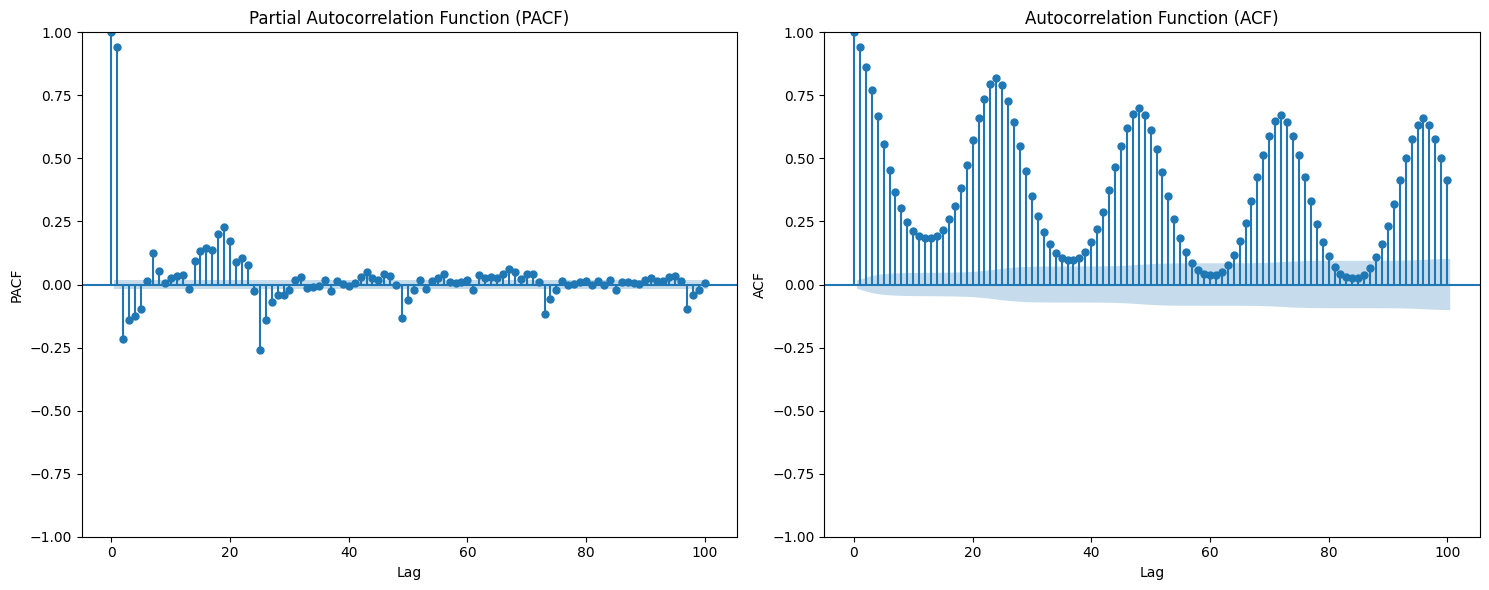

In [54]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,6))

df_hourly=df['Vehicles'].resample('h').mean()
# Plot ACF to identify significant lags
plot_pacf(df_hourly,lags=100,ax=ax1)
ax1.set_title('Partial Autocorrelation Function (PACF)')
ax1.set_xlabel('Lag')
ax1.set_ylabel('PACF')

# Plot ACF
plot_acf(df_hourly,lags=100,ax=ax2)
ax2.set_title('Autocorrelation Function (ACF)')
ax2.set_xlabel('Lag')
ax2.set_ylabel('ACF')

plt.tight_layout()
plt.show()


''' <span style="color:red">Observations from ACF and PACF plots </span> '''

    ACF (Autocorrelation Function):
   - Strong seasonal pattern with peaks at lags 24, 48, 72, etc., indicating daily seasonality
   - Slowly decaying pattern, suggesting non-stationarity or strong persistence

    PACF (Partial Autocorrelation Function):
   - Significant spike at lag 1
   - Several smaller but significant spikes up to about lag 24
   - Some recurring patterns at multiples of 24 lags

    Model Suggestions

1. **SARIMA (Seasonal ARIMA)**: 
   - Captures both seasonal and non-seasonal components
   - Suggested order: SARIMA(p,d,q)(P,D,Q)24
   - p: Consider 1-3 based on PACF
   - d: Likely 1 for first differencing
   - q: Consider 1-2 based on ACF after differencing
   - P, D, Q: Start with (1,1,1)24 and adjust

2. **Prophet**:
   - Handles multiple seasonalities and trends
   - Good for daily and potential weekly patterns

### visualizing the target variable

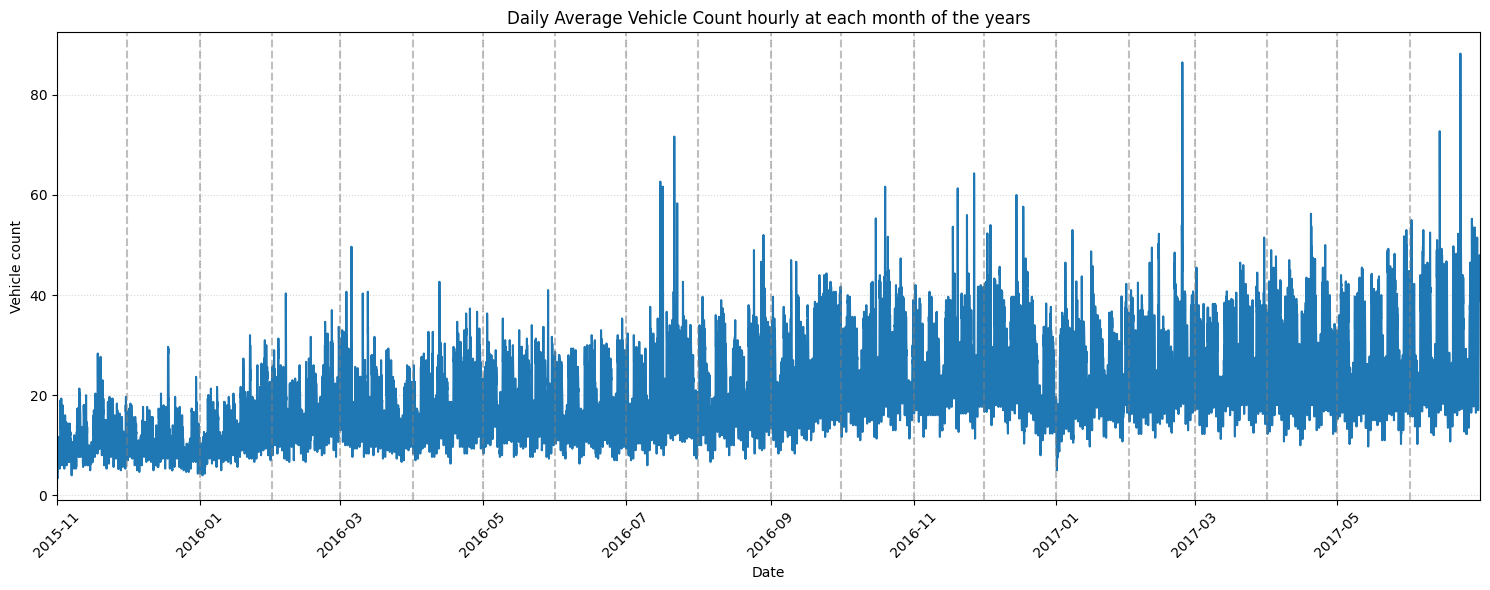

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(15, 6))

df_hourly = df['Vehicles'].resample('h').mean()

plt.plot(df_hourly.index, df_hourly.values)

# Get the range of dates
date_range = pd.date_range(start=df_hourly.index.min(), end=df_hourly.index.max(), freq='MS')

# Add vertical lines for each month
for date in date_range:
    plt.axvline(date, color='gray', linestyle='--', alpha=0.5)

plt.xticks(rotation=45)
plt.ylabel('Vehicle count')
plt.title('Daily Average Vehicle Count hourly at each month of the years')
plt.grid(True, linestyle=':', alpha=0.5)
plt.xlabel('Date')

# Ensuring all data is shown
plt.xlim(df_hourly.index.min(), df_hourly.index.max())


plt.tight_layout()
plt.show()

- seasonal decomposing 

''' There is no seasoanity in hourly based data ,can be seen through acf pacf plot '''

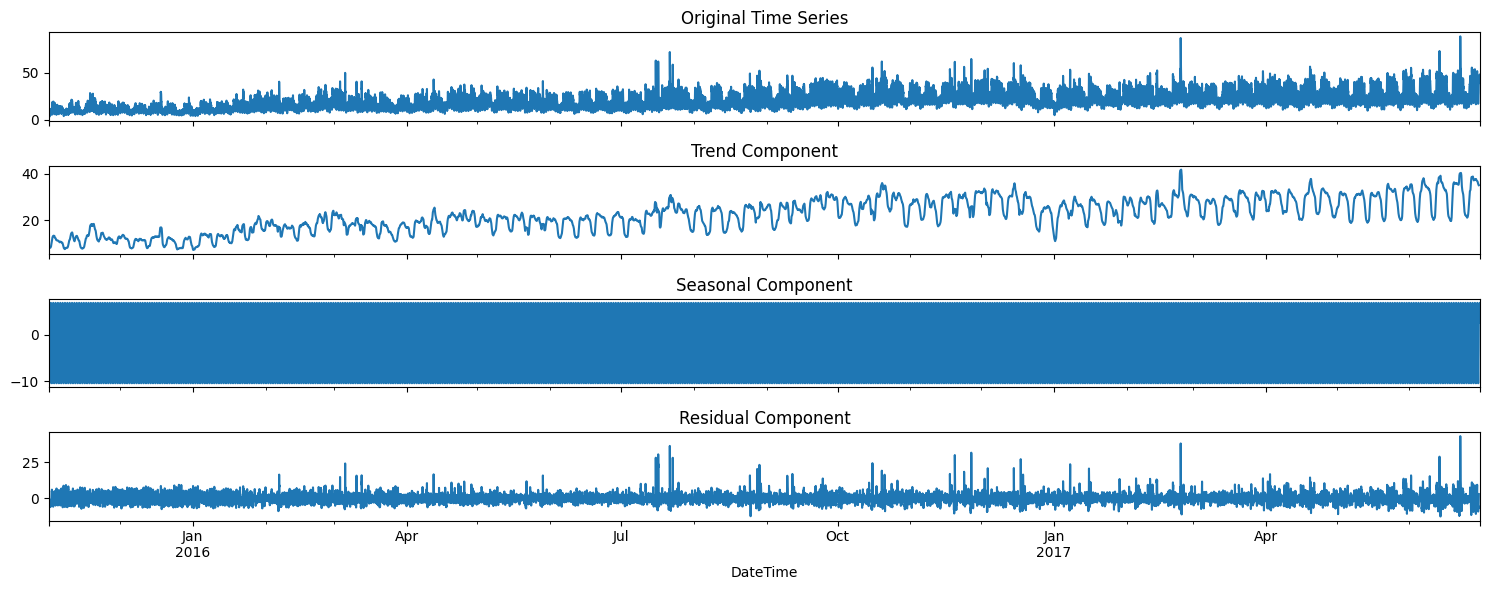

In [56]:
# Perform seasonal decomposition 
from statsmodels.tsa.seasonal import seasonal_decompose
daily_decomposition = seasonal_decompose(df['Vehicles'].resample('h').mean(), model='additive', period=24) # check for daily seasonality

# Plot the decomposition results
fig, axes = plt.subplots(4, 1, figsize=(15, 6), sharex=True)

df_hourly.plot(ax=axes[0], title='Original Time Series')
daily_decomposition.trend.plot(ax=axes[1], title='Trend Component')
daily_decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
daily_decomposition.resid.plot(ax=axes[3], title='Residual Component')

plt.tight_layout()
plt.show()

<span style="color:red">''' Daily pattern is also present '''</span>

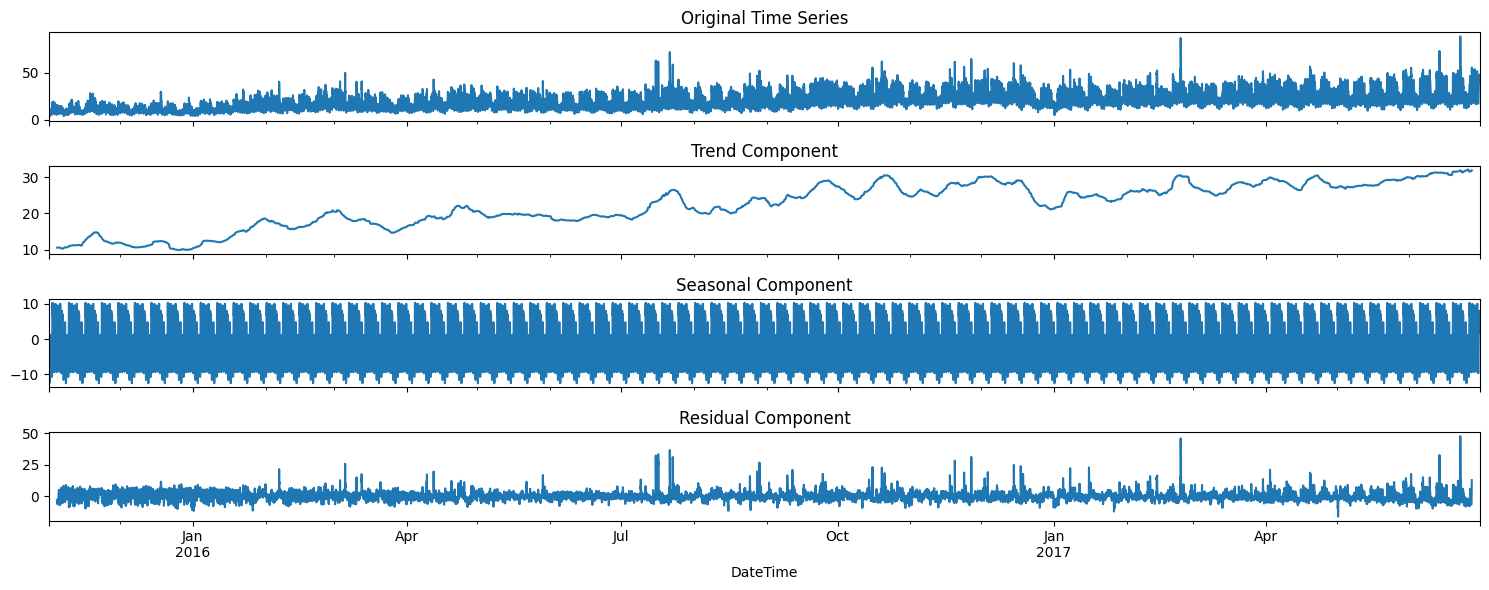

In [57]:
# Perform seasonal decomposition 
from statsmodels.tsa.seasonal import seasonal_decompose
weeekly_decomposition = seasonal_decompose(df['Vehicles'].resample('h').mean(), model='additive', period=24*7) #check for weekly seasonality

# Plot the decomposition results
fig, axes = plt.subplots(4, 1, figsize=(15, 6), sharex=True)

df_hourly.plot(ax=axes[0], title='Original Time Series')
weeekly_decomposition.trend.plot(ax=axes[1], title='Trend Component')
weeekly_decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
weeekly_decomposition.resid.plot(ax=axes[3], title='Residual Component')

plt.tight_layout()
plt.show()

<span style="color:red">''' weekly pattern is also present '''</span>

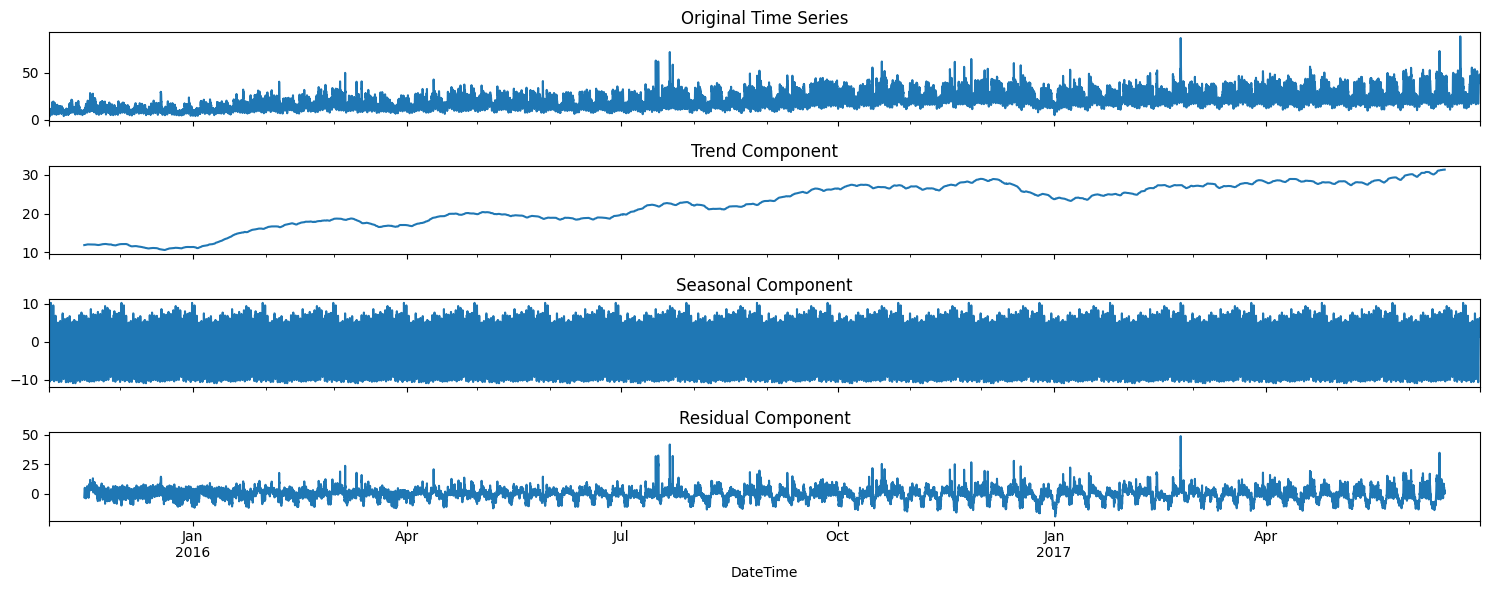

In [58]:
# Perform seasonal decomposition 
from statsmodels.tsa.seasonal import seasonal_decompose
monthly_decomposition = seasonal_decompose(df['Vehicles'].resample('h').mean(), model='additive', period=24*30) # check for monthly seasonality

# Plot the decomposition results
fig, axes = plt.subplots(4, 1, figsize=(15, 6), sharex=True)

df_hourly.plot(ax=axes[0], title='Original Time Series')
monthly_decomposition.trend.plot(ax=axes[1], title='Trend Component')
monthly_decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
monthly_decomposition.resid.plot(ax=axes[3], title='Residual Component')

plt.tight_layout()
plt.show()



<span style="color:red">"Monthly seasonality is also present "</span>

### Check Stationarity using Statistical Test- ADF and KPSS

In [59]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    if result[1]<0.05:
        print("Series is stationary")
    else:
        print("Series is not statioanry")

In [60]:
perform_adf_test(df['Vehicles'].resample('D').mean())

ADF Statistic: -1.019845
p-value: 0.745957
Critical Values:
   1%: -3.44152019959894
   5%: -2.8664679191981297
   10%: -2.569394451038919
Series is not statioanry


In [61]:
import warnings
warnings.filterwarnings('ignore')

def kpss_test(Series):
    stats, p , lag, critical_values=kpss(Series,'ct')
    print(f'Test Statistics : {stats}')
    print(f'p-value : {p}')
    print(f' No. of lags used : {lag}')
    print(f'Critical Values : {critical_values}')

    if p<0.05:
        print("Series is not stationary")
    else:
        print("Series is statioanry")


In [62]:
kpss_test(df['Vehicles'].resample('D').mean())

Test Statistics : 0.6525472988119432
p-value : 0.01
 No. of lags used : 2
Critical Values : {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not stationary


<span style="color:red">"The resampled Daily  data is not stationarity by the statistical test performed and by visual inspection"</span>

#### Make Stationary the Traget Variable

DateTime
2015-11-01   -1.352113
2015-11-02    0.333333
2015-11-03   -0.194444
2015-11-04    0.027778
2015-11-05    0.013889
                ...   
2017-06-26    0.729167
2017-06-27   -0.041667
2017-06-28    0.062500
2017-06-29   -0.041667
2017-06-30   -0.114583
Freq: D, Name: Vehicles, Length: 608, dtype: float64

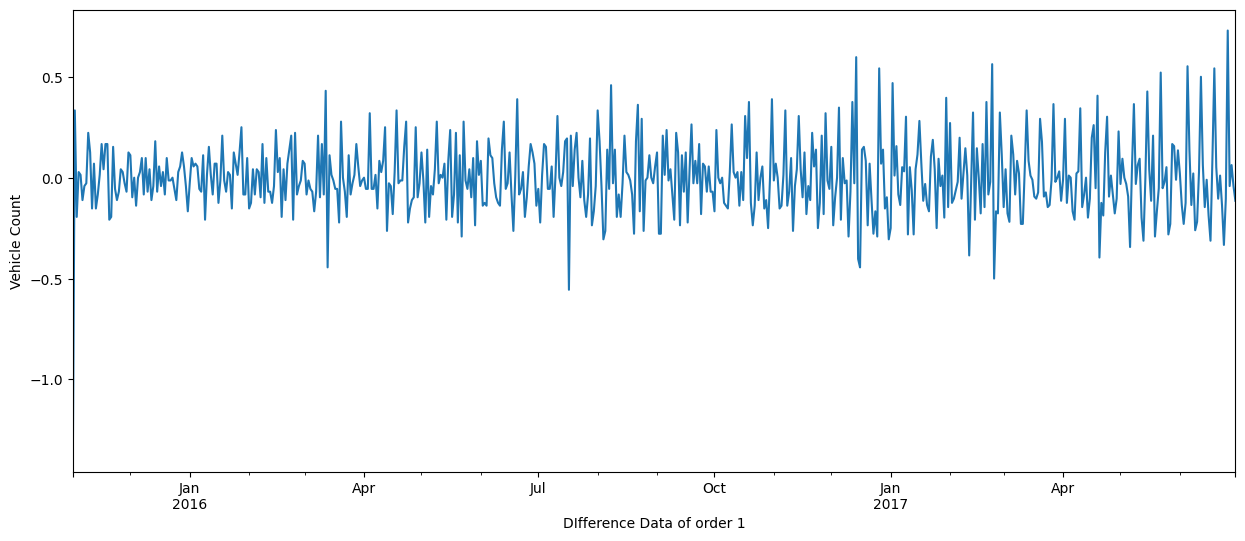

In [63]:
plt.figure(figsize=(15,6))
df_diff=df['Vehicles'].diff().dropna().resample('D').mean()
df_diff.plot()
plt.xlabel('DIfference Data of order 1')
plt.ylabel('Vehicle Count')
df_diff

In [64]:
perform_adf_test(df_diff)


ADF Statistic: -9.035211
p-value: 0.000000
Critical Values:
   1%: -3.44152019959894
   5%: -2.8664679191981297
   10%: -2.569394451038919
Series is stationary


In [65]:
kpss_test(df_diff)

Test Statistics : 0.09928977303678585
p-value : 0.1
 No. of lags used : 72
Critical Values : {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is statioanry


<span style="color:red">"Series now become Stationary by order 1 Differenecing</span>

## Model Building

In [66]:
merged_df.set_index('DateTime',inplace=True)

- train test split


In [67]:
x=merged_df['Vehicles'].resample('D').mean()
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]

- SARIMA MODELLING

Grid Search

In [68]:
from pmdarima import auto_arima
sarima = auto_arima(
    x_train,
    start_p=1,
    start_q=1,
    max_p=3,  # Reduced max_p
    max_q=3,  # Reduced max_q
    d=None,
    m=7,
    start_P=0,
    start_Q=0,
    max_P=2,  # Reduced max_P
    max_Q=2,  # Reduced max_Q
    D=None,
    seasonal=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion='aic',
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=2533.130, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2642.985, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2274.327, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2455.654, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2641.062, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=2644.740, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=2188.850, Time=0.32 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=2072.841, Time=0.90 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=2071.055, Time=0.52 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=2460.839, Time=0.22 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=2072.825, Time=1.38 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=2379.989, Time=0.38 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=2073.851, Time=1.79 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=2091.022, Time=0.36 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept

                                     SARIMAX Results                                     
Dep. Variable:                          Vehicles   No. Observations:                  486
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -992.707
Date:                           Sun, 07 Jul 2024   AIC                           1999.415
Time:                                   17:08:26   BIC                           2028.602
Sample:                               11-01-2015   HQIC                          2010.890
                                    - 02-28-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6650      0.044     15.082      0.000       0.579       0.751
ar.L2          0.0711      0.060      1.180

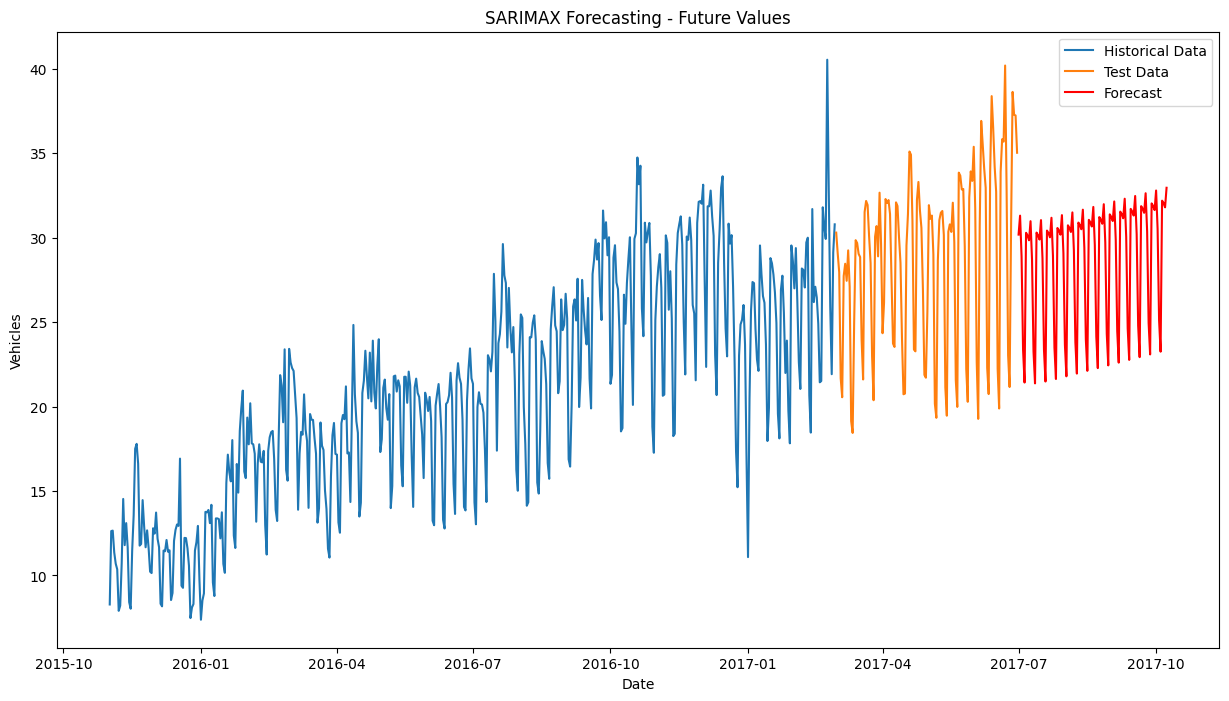


Forecasted values:
2017-07-01: 30.18
2017-07-02: 31.31
2017-07-03: 28.90
2017-07-04: 23.38
2017-07-05: 21.42
2017-07-06: 30.29
2017-07-07: 30.13
2017-07-08: 29.85
2017-07-09: 30.98
2017-07-10: 28.69
2017-07-11: 23.25
2017-07-12: 21.37
2017-07-13: 30.30
2017-07-14: 30.15
2017-07-15: 29.89
2017-07-16: 31.04
2017-07-17: 28.77
2017-07-18: 23.35
2017-07-19: 21.48
2017-07-20: 30.42
2017-07-21: 30.27
2017-07-22: 30.02
2017-07-23: 31.18
2017-07-24: 28.92
2017-07-25: 23.49
2017-07-26: 21.63
2017-07-27: 30.58
2017-07-28: 30.43
2017-07-29: 30.18
2017-07-30: 31.34
2017-07-31: 29.07
2017-08-01: 23.65
2017-08-02: 21.79
2017-08-03: 30.73
2017-08-04: 30.59
2017-08-05: 30.34
2017-08-06: 31.50
2017-08-07: 29.24
2017-08-08: 23.81
2017-08-09: 21.95
2017-08-10: 30.90
2017-08-11: 30.75
2017-08-12: 30.50
2017-08-13: 31.66
2017-08-14: 29.40
2017-08-15: 23.98
2017-08-16: 22.11
2017-08-17: 31.06
2017-08-18: 30.91
2017-08-19: 30.66
2017-08-20: 31.82
2017-08-21: 29.56
2017-08-22: 24.14
2017-08-23: 22.28
2017-08-

In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(x_train, order=(3, 1, 1),seasonal_order=(1,1,1,7))
results = model.fit()

print(results.summary())

# Forecast future values
forecast_steps = 100
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean

# Create date range for future predictions
last_date = x_test.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),periods=forecast_steps)

# Plot results
plt.figure(figsize=(15, 8))
plt.plot(x_train.index, x_train, label='Historical Data')
plt.plot(x_test.index, x_test, label='Test Data')
plt.plot(future_dates, forecast_mean, color='red', label='Forecast')

plt.legend()
plt.title('SARIMAX Forecasting - Future Values')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.show()

# Print the forecasted values
print("\nForecasted values:")
for date, value in zip(future_dates, forecast_mean):
    print(f"{date.date()}: {value:.2f}")

In [70]:
forecast_values = forecast.predicted_mean
from sklearn.metrics import mean_absolute_error
# Calculate mean absolute error
mae = mean_absolute_error(y[-forecast_steps:], forecast_values)
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 17.734938329677135


In [71]:
from sklearn.metrics import mean_squared_error
forecast_values = forecast.predicted_mean
mse = mean_squared_error(y[-forecast_steps:], forecast_values)
print(mse)

355.1894239273872


<span style="color:red">"Despite of getting optimum parameter using auto_arima SARIMAX Modelling is not capturing the variabilty"</span>

### Gradient Boosting Regresssor 

In [72]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Assuming merged_df is already defined
vehicles_feature = ['Vehicles_lag1', 'Vehicles_lag2', 'Vehicles_lag3', 'Vehicles_lag4', 'Vehicles_lag5']
for i in vehicles_feature:
    merged_df[i] = merged_df[i].bfill()

split_date = merged_df.index[int(len(merged_df.resample('h')) * 0.8)]

# Splitting the dataset into training and validation sets
train_data = merged_df.loc[merged_df.index <= split_date]
val_data = merged_df.loc[merged_df.index > split_date]

features = ['Junction','date_year', 'date_month', 'date_days', 'day_hour', 'day_of_week', 'date_is_weekend',
            'Vehicles_lag1', 'Vehicles_lag2', 'Vehicles_lag3', 'Vehicles_lag4', 'Vehicles_lag5',
            'tempC', 'humidity', 'precipMM', 'windspeedKmph']

X = train_data[features].resample('h').mean()
y = train_data['Vehicles'].resample('h').mean()


'''Split the dataset for training and validation:'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Prepare validation data consistently with training data
X_val = val_data[features].resample('h').mean()
y_val = val_data['Vehicles'].resample('h').mean()

model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    loss='squared_error'
)
model.fit(X_train, y_train)

# Make predictions

predictions = model.predict(X_test)
forecast = model.predict(X_val)

# Evaluate the model
rmse_test = np.sqrt(mean_squared_error(y_test, predictions))
rmse_forecast = np.sqrt(mean_squared_error(y_val, forecast))

print(f'RMSE (Test): {rmse_test}')
print(f'RMSE (Forecast): {rmse_forecast}')

# Print some predictions and actual values for comparison
comparison_test_pred = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
comparison_forecast_pred = pd.DataFrame({'Actual': y_val, 'Predicted': forecast})
print("Test Predictions:")
print(comparison_test_pred.head())
print("\nForecast Predictions:")
print(comparison_forecast_pred.head())

RMSE (Test): 3.3042352619504936
RMSE (Forecast): 3.8992417338912344
Test Predictions:
                        Actual  Predicted
DateTime                                 
2016-11-24 03:00:00  18.333333  17.856537
2016-11-24 04:00:00  17.666667  15.912414
2016-11-24 05:00:00  16.666667  15.773517
2016-11-24 06:00:00  18.000000  17.752623
2016-11-24 07:00:00  20.000000  19.306266

Forecast Predictions:
                     Actual  Predicted
DateTime                              
2017-03-01 10:00:00   28.75  30.107179
2017-03-01 11:00:00   36.50  29.704868
2017-03-01 12:00:00   36.75  33.342289
2017-03-01 13:00:00   31.75  31.483133
2017-03-01 14:00:00   37.00  30.894983


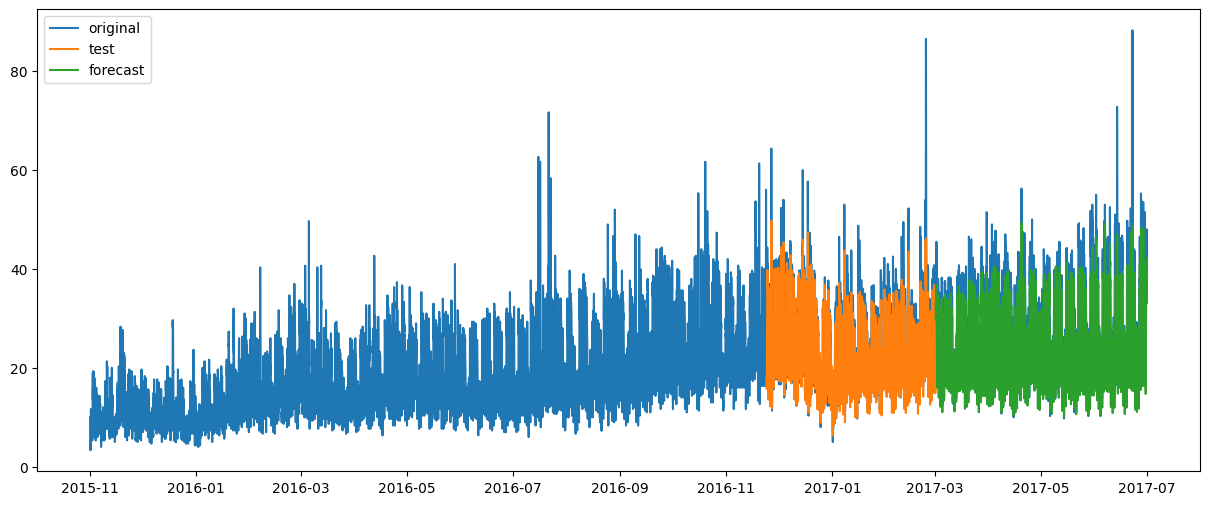

In [73]:
plt.figure(figsize=(15,6))
plt.plot(merged_df['Vehicles'].resample('h').mean(),label='original')
plt.plot(comparison_test_pred.iloc[:,1],label='test')
plt.plot(comparison_forecast_pred.iloc[:,1],label='forecast')
plt.legend()

In [74]:
from sklearn.model_selection import TimeSeriesSplit
# Time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

for train_index, test_index in tscv.split(X_train):
    X_cv_train, X_cv_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_cv_train, y_cv_test = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model.fit(X_cv_train, y_cv_train)
    predictions = model.predict(X_cv_test)
    cv_scores.append(np.sqrt(mean_squared_error(y_cv_test, predictions)))


In [75]:
cv_scores

[2.636858452190582,
 2.4131713822856886,
 2.8044908366328203,
 3.181807454683773,
 3.131466555162296]

In [76]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
# Evaluate model performance
rmse = np.sqrt(mean_squared_error(y_val, forecast))
mae = mean_absolute_error(y_val, forecast)
r2 = r2_score(y_val, forecast)

print(f'Cross-validation RMSE: {np.mean(cv_scores):.2f} (+/- {np.std(cv_scores):.2f})')
print(f'Validation RMSE: {rmse:.2f}')
print(f'Validation MAE: {mae:.2f}')
print(f'Validation R2: {r2:.2f}')

Cross-validation RMSE: 2.83 (+/- 0.29)
Validation RMSE: 3.90
Validation MAE: 2.68
Validation R2: 0.85


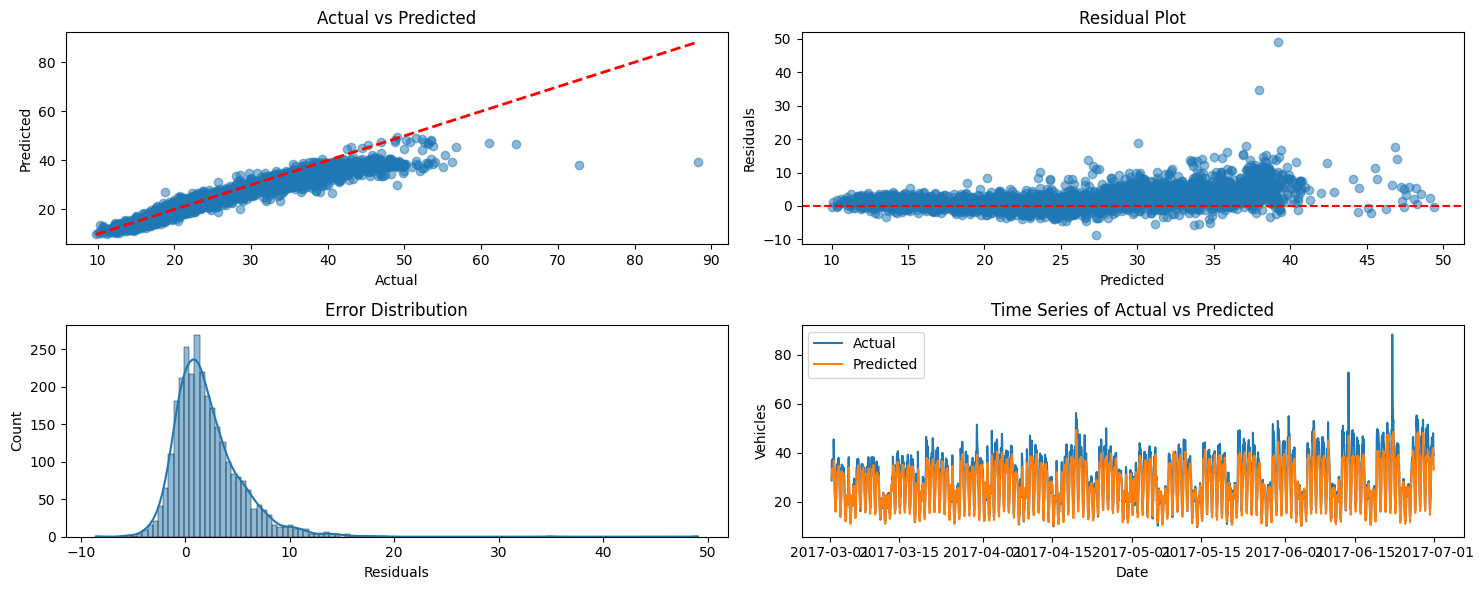


Feature Importance:
            feature  importance
7     Vehicles_lag1    0.912223
4          day_hour    0.049491
12            tempC    0.009464
2        date_month    0.005751
8     Vehicles_lag2    0.005069
9     Vehicles_lag3    0.004260
14         precipMM    0.002648
11    Vehicles_lag5    0.002593
1         date_year    0.001692
6   date_is_weekend    0.001576
10    Vehicles_lag4    0.001505
5       day_of_week    0.001280
13         humidity    0.001232
15    windspeedKmph    0.001021
3         date_days    0.000195
0          Junction    0.000000


In [77]:
# Visualizations
plt.figure(figsize=(15, 6))

# Actual vs Predicted plot
plt.subplot(2, 2, 1)
plt.scatter(y_val, forecast, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

# Residual plot
residuals = y_val - forecast
plt.subplot(2, 2, 2)
plt.scatter(forecast, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Error distribution
plt.subplot(2, 2, 3)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Error Distribution')

# Time series plot
plt.subplot(2, 2, 4)
plt.plot(y_val.index, y_val, label='Actual')
plt.plot(y_val.index, forecast, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.title('Time Series of Actual vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

<span style="color:red">"The model demonstrates strong alignment and correlation with actual values overall, capturing general trends and seasonal patterns effectively. However, it exhibits systematic underestimation for higher values and struggles to predict extreme peaks accurately. Addressing these issues could involve revisiting model parameters, considering alternative models, or implementing specific adjustments to handle extreme events better."</span>

### Refinement in Gradient Boosting Regressor

- removed all unimportant features that have negligibe importance

In [78]:
features = ['day_hour','date_is_weekend',
            'Vehicles_lag1','Vehicles_lag2','Vehicles_lag3',
            'tempC',]

X = train_data[features].resample('h').mean()
y = train_data['Vehicles'].resample('h').mean()


'''Split the dataset for training and validation:'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Prepare validation data consistently with training data
X_val = val_data[features].resample('h').mean()
y_val = val_data['Vehicles'].resample('h').mean()

model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    loss='squared_error'
)
model.fit(X_train, y_train)

# Make predictions

predictions = model.predict(X_test)
forecast = model.predict(X_val)

# Evaluate the model
rmse_test = np.sqrt(mean_squared_error(y_test, predictions))
rmse_forecast = np.sqrt(mean_squared_error(y_val, forecast))

print(f'RMSE (Test): {rmse_test}')
print(f'RMSE (Forecast): {rmse_forecast}')

# Print some predictions and actual values for comparison
comparison_test_pred = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
comparison_forecast_pred = pd.DataFrame({'Actual': y_val, 'Predicted': forecast})
print("Test Predictions:")
print(comparison_test_pred.head())
print("\nForecast Predictions:")
print(comparison_forecast_pred.head())

RMSE (Test): 2.863036687571536
RMSE (Forecast): 3.042503044059301
Test Predictions:
                        Actual  Predicted
DateTime                                 
2016-11-24 03:00:00  18.333333  17.648221
2016-11-24 04:00:00  17.666667  15.631877
2016-11-24 05:00:00  16.666667  15.690093
2016-11-24 06:00:00  18.000000  17.865228
2016-11-24 07:00:00  20.000000  19.265381

Forecast Predictions:
                     Actual  Predicted
DateTime                              
2017-03-01 10:00:00   28.75  31.371982
2017-03-01 11:00:00   36.50  32.011612
2017-03-01 12:00:00   36.75  35.052688
2017-03-01 13:00:00   31.75  32.040405
2017-03-01 14:00:00   37.00  33.190186


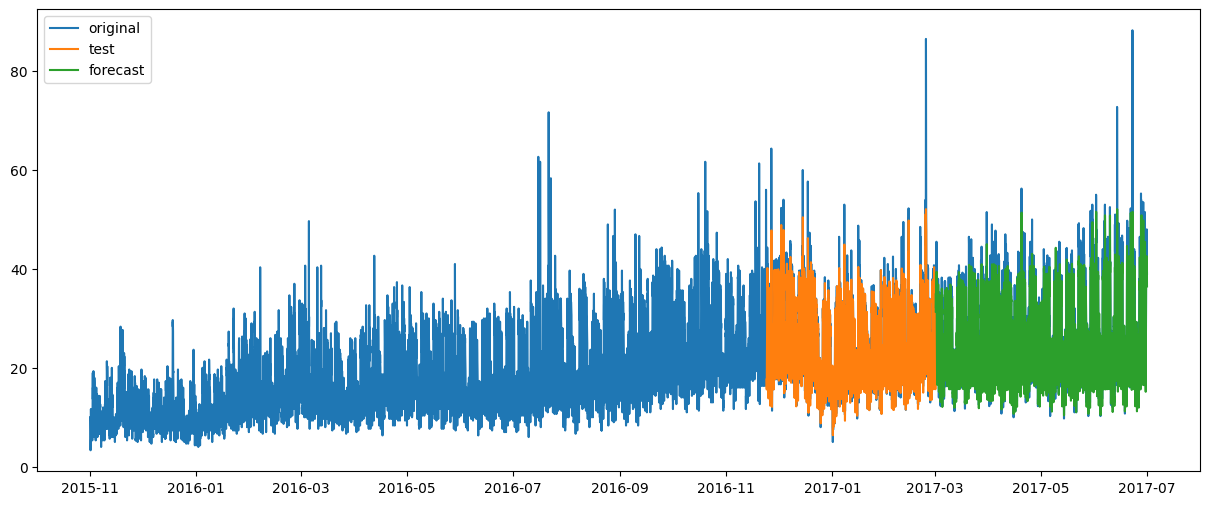

In [79]:
plt.figure(figsize=(15,6))
plt.plot(merged_df['Vehicles'].resample('h').mean(),label='original')
plt.plot(comparison_test_pred.iloc[:,1],label='test')
plt.plot(comparison_forecast_pred.iloc[:,1],label='forecast')
plt.legend()

In [80]:
from sklearn.model_selection import TimeSeriesSplit
# Time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

for train_index, test_index in tscv.split(X_train):
    X_cv_train, X_cv_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_cv_train, y_cv_test = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model.fit(X_cv_train, y_cv_train)
    predictions = model.predict(X_cv_test)
    cv_scores.append(np.sqrt(mean_squared_error(y_cv_test, predictions)))


In [81]:
cv_scores

[2.518637113862303,
 2.333301228281019,
 2.836366586397971,
 3.221294434172426,
 3.2440438030824366]

In [82]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
# Evaluate model performance
rmse = np.sqrt(mean_squared_error(y_val, forecast))
mae = mean_absolute_error(y_val, forecast)
r2 = r2_score(y_val, forecast)

print(f'Cross-validation RMSE: {np.mean(cv_scores):.2f} (+/- {np.std(cv_scores):.2f})')
print(f'Validation RMSE: {rmse:.2f}')
print(f'Validation MAE: {mae:.2f}')
print(f'Validation R2: {r2:.2f}')

Cross-validation RMSE: 2.83 (+/- 0.37)
Validation RMSE: 3.04
Validation MAE: 2.05
Validation R2: 0.91


<span style="color:red">"There is improvement in R2 score from 0.86 to 0.9</span>

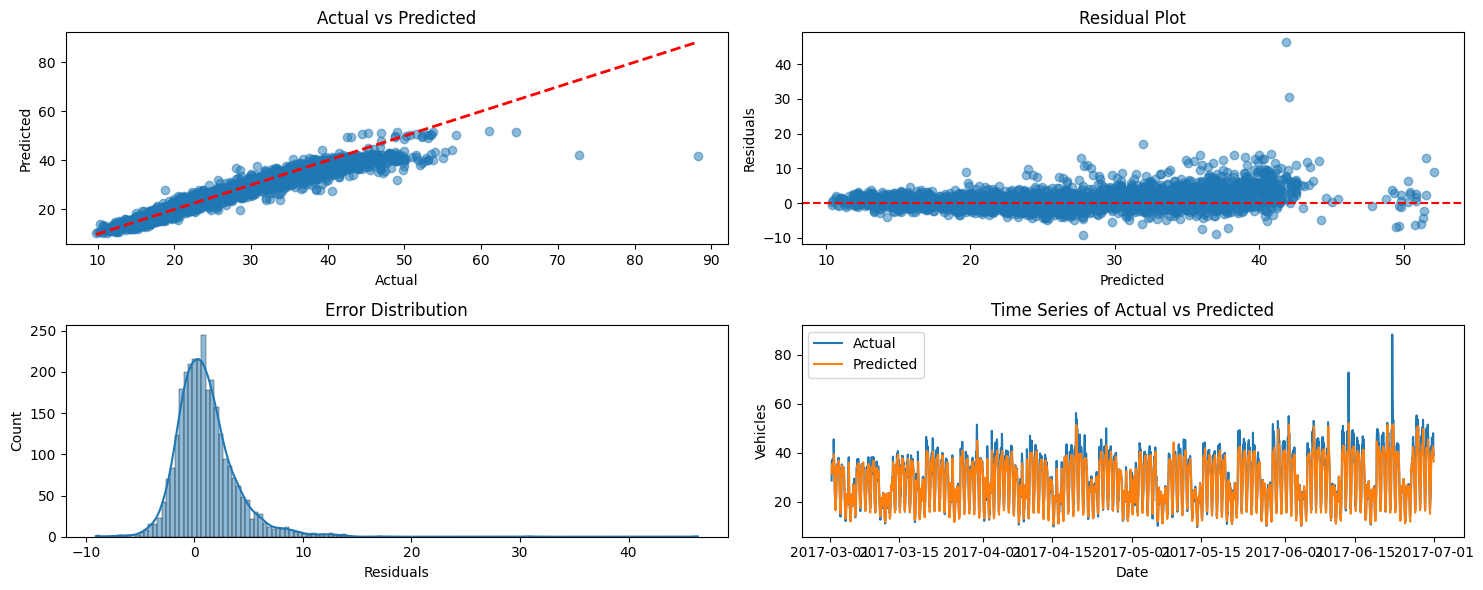


Feature Importance:
           feature  importance
2    Vehicles_lag1    0.919454
0         day_hour    0.051658
5            tempC    0.010748
4    Vehicles_lag3    0.008360
3    Vehicles_lag2    0.007316
1  date_is_weekend    0.002464


In [83]:
# Visualizations
plt.figure(figsize=(15, 6))

# Actual vs Predicted plot
plt.subplot(2, 2, 1)
plt.scatter(y_val, forecast, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

# Residual plot
residuals = y_val - forecast
plt.subplot(2, 2, 2)
plt.scatter(forecast, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Error distribution
plt.subplot(2, 2, 3)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Error Distribution')

# Time series plot
plt.subplot(2, 2, 4)
plt.plot(y_val.index, y_val, label='Actual')
plt.plot(y_val.index, forecast, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.title('Time Series of Actual vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)